# EEG-based Prediction of tDCS Treatment Response
This notebook includes the preprocessing of EEG data and class balancing of 24 patients who did the tDCS treatment.

## 0. Load libraries

In [1]:
from google.colab import drive
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (
    f1_score, roc_auc_score, precision_score, recall_score,
    classification_report, confusion_matrix, roc_curve, auc
)
from sklearn.inspection import permutation_importance
import warnings
warnings.filterwarnings('ignore')

!pip install pymoo

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.7/72.7 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 49.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.5/309.5 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 786.8/786.8 kB 25.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 kB 3.1 MB/s eta 0:00:00


## 1. Load EEG Feature Data
This section loads all feature datasets (band power, PLV, envelope mean and std) from Excel files stored in Google Drive. Columns are renamed consistently to allow for clear merging and manipulation later on.

In [2]:
drive.mount('/content/drive')
path = '/content/drive/MyDrive/TFG/datos_ml/'

# Load from drive
df_band = pd.read_excel(path + 'subjects_band_powers.xlsx')
df_plv = pd.read_excel(path + 'plv_subjects.xlsx')
df_env_mean = pd.read_excel(path + 'envelope_table.xlsx', sheet_name='mean')
df_env_std = pd.read_excel(path + 'envelope_table.xlsx', sheet_name='std_dev')

# Rename
df_band.columns = ['Subject' if c == df_band.columns[0] else f'band_{c}' for c in df_band.columns];
df_plv.columns = ['Subject' if c == df_plv.columns[0] else f'plv_{c}' for c in df_plv.columns];
df_env_mean.columns = ['Subject' if c == df_env_mean.columns[0] else f'env_mean_{c}' for c in df_env_mean.columns];
df_env_std.columns = ['Subject' if c == df_env_std.columns[0] else f'env_std_{c}' for c in df_env_std.columns];

# Print the size of each table
print("envelope_table:", df_env_mean.shape)
print("envelope_table:", df_env_std.shape)
print("plv_subjects:", df_plv.shape)
print("subjects_band_powers:", df_band.shape)

Mounted at /content/drive
envelope_table: (24, 57)
envelope_table: (24, 57)
plv_subjects: (24, 53)
subjects_band_powers: (24, 281)


## 2. Clean Outliers
For each EEG feature group, values outside of (mean - 3std dev, mean + 3std dev) range are removed (per group). This step ensures robustness by eliminating outlier values that could bias normalization and model training.

In [3]:
def clean_outliers_from_raw(df, mode='band'):
    # Auto detectar ID column
    id_col = 'Subjects' if 'Subjects' in df.columns else 'Subject'

    # Pasar a formato largo
    df_long = df.melt(id_vars=id_col, var_name='Feature', value_name='Value')

    if mode == 'band':
        df_long["Band"] = df_long["Feature"].str.extract(r'_([^_]+)$')[0]
        df_long["Region"] = df_long["Feature"].str.extract(
            r'^band_(?:PRE|POST)_[^_]+_([^_]+(?:_[^_]+)*)_[^_]+$')[0]
        df_long["Group"] = df_long["Region"] + "_" + df_long["Band"]

    elif mode == 'region':
        # Captura cualquier patrón que termine en _POST_OC o _PRE_OC, etc.
        df_long["Region"] = df_long["Feature"].str.extract(r'^(.*)_[A-Z]{2,}_[A-Z]{2,}$')[0]
        df_long["Group"] = df_long["Region"]


    else:
        raise ValueError("Mode must be 'band' or 'region'")

    # Filtrar grupos válidos
    df_long = df_long.dropna(subset=["Group"])

    # Guardar conteo total
    n_total = len(df_long)

    def remove_outliers(group):
        if len(group) < 5:
            return group
        mean, std = group["Value"].mean(), group["Value"].std()
        filtered = group[(group["Value"] >= mean - 3 * std) & (group["Value"] <= mean + 3 * std)]
        group_name = group["Group"].iloc[0]
        print(f"{group_name}: {len(group) - len(filtered)} outliers removed")
        return filtered

    df_clean = df_long.groupby("Group", group_keys=False, sort=False).apply(remove_outliers).reset_index(drop=True)

    # Cálculo de % eliminado
    n_clean = len(df_clean)
    pct_removed = (n_total - n_clean) / n_total * 100
    print(f"\nPercentage of values removed as outliers: {pct_removed:.2f}%\n")

    # Volver a wide
    return df_clean.pivot(index=id_col, columns="Feature", values="Value").reset_index()

# Apply cleaning
df_band_clean     = clean_outliers_from_raw(df_band, mode='band')
df_env_mean_clean = clean_outliers_from_raw(df_env_mean, mode='region')
df_env_std_clean  = clean_outliers_from_raw(df_env_std, mode='region')

C3_Delta: 4 outliers removed
C3_Theta: 4 outliers removed
C3_Alpha: 5 outliers removed
C3_Beta: 4 outliers removed
C3_Gamma: 4 outliers removed
C4_Delta: 4 outliers removed
C4_Theta: 4 outliers removed
C4_Alpha: 4 outliers removed
C4_Beta: 4 outliers removed
C4_Gamma: 6 outliers removed
C3_proximity_Delta: 6 outliers removed
C3_proximity_Theta: 4 outliers removed
C3_proximity_Alpha: 4 outliers removed
C3_proximity_Beta: 4 outliers removed
C3_proximity_Gamma: 6 outliers removed
C4_proximity_Delta: 6 outliers removed
C4_proximity_Theta: 5 outliers removed
C4_proximity_Alpha: 5 outliers removed
C4_proximity_Beta: 5 outliers removed
C4_proximity_Gamma: 7 outliers removed
Left_Frontal_Delta: 5 outliers removed
Left_Frontal_Theta: 6 outliers removed
Left_Frontal_Alpha: 6 outliers removed
Left_Frontal_Beta: 4 outliers removed
Left_Frontal_Gamma: 8 outliers removed
Right_Frontal_Delta: 4 outliers removed
Right_Frontal_Theta: 5 outliers removed
Right_Frontal_Alpha: 4 outliers removed
Right_Fron

##3. Impute missing values
After outlier removal, some cells become NaN. This section imputes missing values using the mean of each feature (column). Maintaining the dataset structure and avoiding loss of data in our small data set.

In [4]:
def impute_missing(df, name):
    feature_cols = df.columns.drop('Subject')
    n_missing = df[feature_cols].isnull().sum()
    print(f"\nNaNs in {name} before imputation:")
    print(n_missing[n_missing > 0])
    df[feature_cols] = df[feature_cols].fillna(df[feature_cols].mean())
    assert df[feature_cols].isnull().sum().sum() == 0, f"Still NaNs in {name}"
    print(f"Missing values in {name} imputed with column means.")
    return df

df_band_clean     = impute_missing(df_band_clean, 'band_clean')
df_env_mean_clean = impute_missing(df_env_mean_clean, 'env_mean_clean')
df_env_std_clean  = impute_missing(df_env_std_clean, 'env_std_clean')


NaNs in band_clean before imputation:
Feature
band_POST_OA_C3_Alpha                     2
band_POST_OA_C3_Beta                      2
band_POST_OA_C3_Delta                     2
band_POST_OA_C3_Gamma                     1
band_POST_OA_C3_Theta                     2
                                         ..
band_PRE_OC_Right_frontocentral_Gamma     2
band_PRE_OC_Right_frontocentral_Theta     2
band_PRE_OC_Right_occitoparietal_Delta    1
band_PRE_OC_Right_occitoparietal_Gamma    1
band_PRE_OC_Right_occitoparietal_Theta    1
Length: 253, dtype: int64
Missing values in band_clean imputed with column means.

NaNs in env_mean_clean before imputation:
Feature
env_mean_C3_PRE_OA                       1
env_mean_C3_proximity_POST_OC            3
env_mean_C3_proximity_PRE_OA             1
env_mean_C4_POST_OC                      1
env_mean_C4_PRE_OA                       1
env_mean_C4_PRE_OC                       2
env_mean_C4_proximity_POST_OA            1
env_mean_C4_proximity_POST_OC      

## 4. Normalize Features
This function applies MinMax scaling (0 to 1) to all feature columns, ensuring that each features are on comparable scales.

In [5]:
def scale_features(df):
    df_scaled = df.copy()
    cols = df.columns.drop('Subject')
    df_scaled[cols] = df_scaled[cols].T.apply(
        lambda x: MinMaxScaler().fit_transform(x.values.reshape(-1, 1)).ravel()
    ).T
    return df_scaled

df_band_scaled = scale_features(df_band_clean)
df_env_mean_scaled = scale_features(df_env_mean_clean)
df_env_std_scaled  = scale_features(df_env_std_clean)

## 5. DIFF feature
This section computes the difference between (POST - PRE) feature values for each EEG variable. This feature captures the increase or decrease of any variable due to the tDCS treatment.

In [6]:
def compute_differences(df, prefix):
    diff_data = {}
    for col in df.columns:
        if '_POST_' in col:
            pre_col = col.replace('_POST_', '_PRE_')
            if pre_col in df.columns:
                diff_name = col.replace('_POST_', '_DIFF_')
                diff_data[diff_name] = df[col] - df[pre_col]
    return pd.concat([df[['Subject']], pd.DataFrame(diff_data)], axis=1)

df_band_diff = compute_differences(df_band_scaled, 'band')
df_env_mean_diff = compute_differences(df_env_mean_scaled, 'env_mean')
df_env_std_diff = compute_differences(df_env_std_scaled, 'env_std')

# Print the size of each table
print("diff_band_table:", df_band_diff.shape)
print("diff_envelope_table:", df_env_mean_diff.shape)
print("diff_env_std:", df_env_std_diff.shape)

diff_band_table: (24, 141)
diff_envelope_table: (24, 29)
diff_env_std: (24, 29)


## 6. Merge All Scaled Features
All features are merged, creating the features dataset with no NaN values.

In [7]:
df_all = df_band_scaled.merge(df_env_mean_scaled, on="Subject") \
                       .merge(df_env_std_scaled, on="Subject") \
                       .merge(df_plv, on="Subject") \
                       .merge(df_band_diff, on="Subject") \
                       .merge(df_env_mean_diff, on="Subject") \
                       .merge(df_env_std_diff, on="Subject")

assert df_all.isnull().sum().sum() == 0, "Nulls after merge"
print("Final feature set shape:", df_all.shape)

Final feature set shape: (24, 641)


## 7. Compute target with VAS data
The target label (Responder = 1 and Non-Responder = 0) is created based on VAS improvement percentage. Subjects improving 5% or more post-intervention are labeled as responders.

In [8]:
vas = pd.read_excel(path + 'vas_data.xlsx', header=1)
vas.columns = vas.columns.str.strip()
vas = vas[~vas['Protocolo'].str.contains("SHAM", na=False)]

col_pre = [c for c in vas.columns if "VAS_PREVIO" in c]
col_post = [c for c in vas.columns if "VAS_POSTERIOR" in c]

vas[col_pre + col_post] = vas[col_pre + col_post].replace(["NO DATA", "NP", "NaN", "nan", " "], pd.NA).apply(pd.to_numeric, errors='coerce')
vas["Mean_Pre"] = vas[col_pre].mean(axis=1, skipna=True)
vas["Mean_Post"] = vas[col_post].mean(axis=1, skipna=True)

# backup induc
vas["Mean_Pre"] = vas["Mean_Pre"].fillna(vas[[c for c in vas.columns if "PRE_INDUCCION" in c]].apply(pd.to_numeric, errors='coerce').mean(axis=1))
vas["Mean_Post"] = vas["Mean_Post"].fillna(vas[[c for c in vas.columns if "POST_INDUCCION" in c]].apply(pd.to_numeric, errors='coerce').mean(axis=1))

vas["Improvement_%"] = ((vas["Mean_Pre"] - vas["Mean_Post"]) / vas["Mean_Pre"].replace(0, np.nan)) * 100
vas["Improvement_%"] = vas["Improvement_%"].fillna(0)
vas["Target"] = (vas["Improvement_%"] >= 5).astype(int)

df_target = vas[["Sujeto", "Target"]].rename(columns={"Sujeto": "Subject"})

print(df_target)

    Subject  Target
0         1       0
1         2       0
3         3       1
4         4       0
6         5       0
8         6       0
10        7       1
11        8       1
12        9       1
13       10       0
14       11       1
17       12       0
18       13       0
19       14       1
21       15       1
22       16       1
24       17       0
25       18       0
26       19       0
27       20       0
28       21       0
29       22       1
30       23       0
31       24       1
32       25       0
33       26       0
34       27       1
35       28       0
36       29       0
37       30       0


## 8. Merge Features and Target
Merges the final feature dataset with the target variable using subject ID.

In [9]:
df_final = df_all.merge(df_target, on="Subject")
print(df_final.shape)
X = df_final.drop(columns=["Subject", "Target"])
y = df_final["Target"]
X = pd.DataFrame(SimpleImputer(strategy='mean').fit_transform(X), columns=X.columns)

(24, 642)


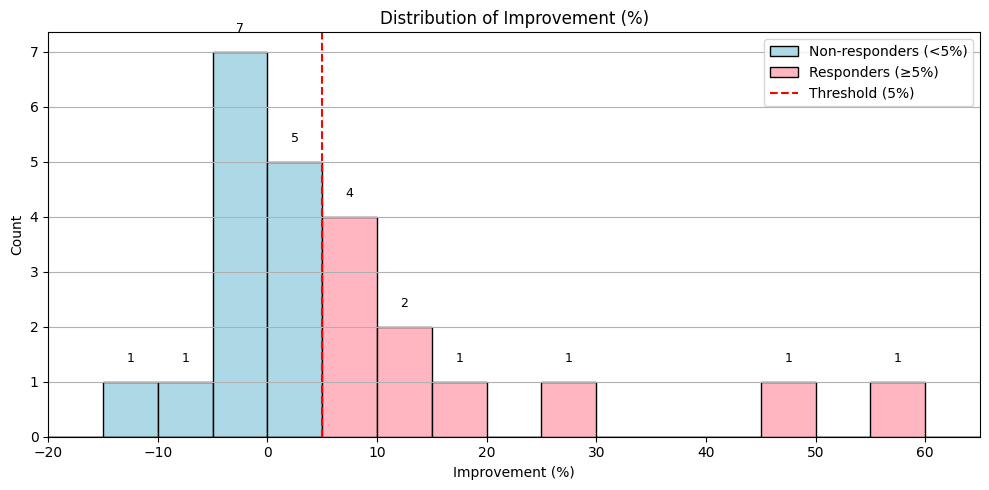

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Data filtered
selected_subjects = df_final['Subject']
filtered_vas = vas[vas['Sujeto'].isin(selected_subjects)].copy()
filtered_vas["Improvement_%"] = ((filtered_vas["Mean_Pre"] - filtered_vas["Mean_Post"]) / filtered_vas["Mean_Pre"].replace(0, np.nan)) * 100
filtered_vas["Improvement_%"] = filtered_vas["Improvement_%"].fillna(0)

# Separate
threshold = 5
data = filtered_vas["Improvement_%"]
responders = data[data >= threshold]
non_responders = data[data < threshold]

min_edge = np.floor(data.min() / 5) * 5 - 5
max_edge = np.ceil(data.max() / 5) * 5 + 5
bins = np.arange(min_edge, max_edge + 1, 5)

# Plot
plt.figure(figsize=(10, 5))
plt.hist(non_responders, bins=bins, color='#ADD8E6', edgecolor='black', label='Non-responders (<5%)')
plt.hist(responders, bins=bins, color='#FFB6C1', edgecolor='black', label='Responders (≥5%)')
plt.axvline(threshold, color='red', linestyle='--', label='Threshold (5%)')

counts, edges = np.histogram(data, bins=bins)
for count, left, right in zip(counts, edges[:-1], edges[1:]):
    if count > 0:
        plt.text((left + right) / 2, count + 0.3, str(count), ha='center', va='bottom', fontsize=9)

# Layout
plt.title("Distribution of Improvement (%)")
plt.xlabel("Improvement (%)")
plt.ylabel("Count")
plt.legend()
plt.grid(axis='y')
plt.xlim(min_edge, max_edge)  # asegurar márgenes amplios
plt.tight_layout()
plt.savefig("Figure12_target_dist_filtered_margin.png", dpi=300, bbox_inches='tight')
plt.show()


In [11]:
print(list(df_final.columns))

['Subject', 'band_POST_OA_C3_Alpha', 'band_POST_OA_C3_Beta', 'band_POST_OA_C3_Delta', 'band_POST_OA_C3_Gamma', 'band_POST_OA_C3_Theta', 'band_POST_OA_C3_proximity_Alpha', 'band_POST_OA_C3_proximity_Beta', 'band_POST_OA_C3_proximity_Delta', 'band_POST_OA_C3_proximity_Gamma', 'band_POST_OA_C3_proximity_Theta', 'band_POST_OA_C4_Alpha', 'band_POST_OA_C4_Beta', 'band_POST_OA_C4_Delta', 'band_POST_OA_C4_Gamma', 'band_POST_OA_C4_Theta', 'band_POST_OA_C4_proximity_Alpha', 'band_POST_OA_C4_proximity_Beta', 'band_POST_OA_C4_proximity_Delta', 'band_POST_OA_C4_proximity_Gamma', 'band_POST_OA_C4_proximity_Theta', 'band_POST_OA_Left_Frontal_Alpha', 'band_POST_OA_Left_Frontal_Beta', 'band_POST_OA_Left_Frontal_Delta', 'band_POST_OA_Left_Frontal_Gamma', 'band_POST_OA_Left_Frontal_Theta', 'band_POST_OA_Left_Temporal_Alpha', 'band_POST_OA_Left_Temporal_Beta', 'band_POST_OA_Left_Temporal_Delta', 'band_POST_OA_Left_Temporal_Gamma', 'band_POST_OA_Left_Temporal_Theta', 'band_POST_OA_Left_centroparietal_Alpha

##9. Split dataset

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

print(f"Training samples: {X_train.shape[0]}")
print(f"Test samples: {X_test.shape[0]}")

Training samples: 16
Test samples: 8


#Feature Selection Optimization by NSGA II algorithm

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Machine Learning (Scikit-Learn)
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.metrics import make_scorer, f1_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_classif

# Optimization (Pymoo)
from pymoo.core.problem import ElementwiseProblem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.operators.crossover.pntx import TwoPointCrossover
from pymoo.operators.mutation.bitflip import BitflipMutation
from pymoo.operators.sampling.rnd import BinaryRandomSampling
from pymoo.optimize import minimize
from pymoo.termination.default import DefaultMultiObjectiveTermination
from pymoo.indicators.hv import HV

# Other Libraries (XGBoost, SHAP)
from xgboost import XGBClassifier
import shap

#Warning
warnings.filterwarnings('ignore')

In [14]:
class EEGFeatureSelection(ElementwiseProblem):
    def __init__(self, X, y, **kwargs):
        # We define 2 objectives (minimize error, minimize features)
        super().__init__(n_var=X.shape[1],
                         n_obj=2,
                         n_ieq_constr=0,
                         xl=0, xu=1,
                         vtype=bool,
                         **kwargs)

        # Store data as numpy arrays for faster indexing
        self.X = X.values if hasattr(X, 'values') else X
        self.y = y.values if hasattr(y, 'values') else y

        # Linear SVM is robust for high-dim data and faster than RF/GradientBoosting
        self.clf = SVC(kernel='linear', C=1, class_weight='balanced', random_state=42)
        self.cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

    def _evaluate(self, x, out, *args, **kwargs):
        mask = x.astype(bool)

        if mask.sum() == 0:
            out["F"] = [1.0, 1.0]
            return

        # 1. Subset the data
        X_subset = self.X[:, mask]

        # 2. Objective 1: Classification Error (1 - F1 Score)
        scores = cross_val_score(self.clf, X_subset, self.y, cv=self.cv, scoring='f1')
        mean_f1 = scores.mean()
        error = 1.0 - mean_f1

        # 3. Objective 2: Complexity (% of features used)
        complexity = mask.sum() / self.n_var

        # Return the two objectives to be MINIMIZED
        out["F"] = [error, complexity]

In [15]:
# 1. Setup the Algorithm
algorithm = NSGA2(
    pop_size=50,
    sampling=BinaryRandomSampling(),
    crossover=TwoPointCrossover(),
    mutation=BitflipMutation(),
    eliminate_duplicates=True
)

# 2. Setup the Problem
problem = EEGFeatureSelection(X_train, y_train)

# 3. Define Robust Termination
termination = DefaultMultiObjectiveTermination(
    xtol=1e-8,
    cvtol=1e-6,
    ftol=0.001,
    period=30,
    n_max_gen=1000
)

# 4. Run the Optimization
print("Starting Optimization with History Tracking...")
res = minimize(
    problem,
    algorithm,
    termination,
    seed=1,
    save_history=True,
    verbose=True
)

print(f"Optimization finished at Generation {res.algorithm.n_gen}!")
print(f"Found {len(res.X)} pareto-optimal solutions.")

Starting Optimization with History Tracking...
n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |       50 |      5 |             - |             -
     2 |      100 |      4 |  0.3684210526 |         ideal
     3 |      150 |      3 |  0.1785714286 |         ideal
     4 |      200 |      3 |  0.1764705882 |         ideal
     5 |      250 |      4 |  0.1363636364 |         ideal
     6 |      300 |      4 |  0.2758620690 |         ideal
     7 |      350 |      6 |  0.2608695652 |         nadir
     8 |      400 |      5 |  0.2307692308 |         ideal
     9 |      450 |      2 |  0.2352941176 |         ideal
    10 |      500 |      6 |  0.0322580645 |         ideal
    11 |      550 |      8 |  0.1538461538 |         ideal
    12 |      600 |      5 |  0.2040816327 |         ideal
    13 |      650 |      7 |  0.0590596335 |             f
    14 |      700 |      9 |  0.0392156863 |         ideal
    15 |      750 |      9 |  0.0239651416 |             f
    16 | 

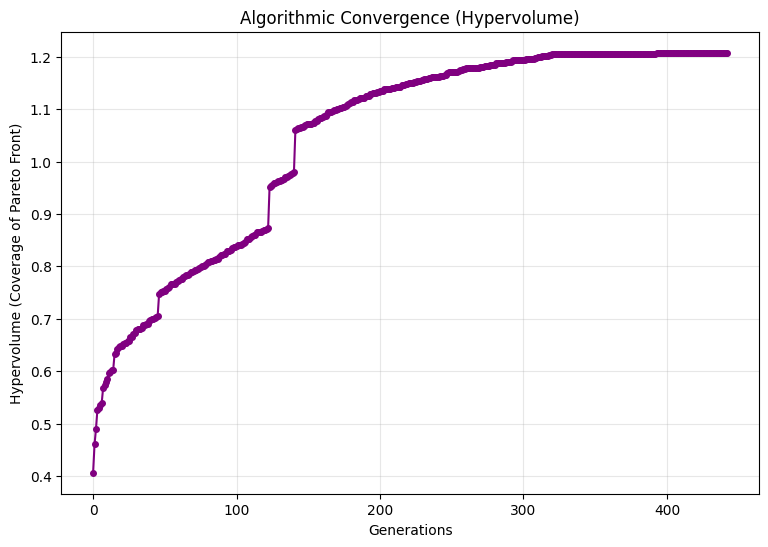

In [16]:
# Ref point must be slightly worse than [1.0, 1.0]
ref_point = np.array([1.1, 1.1])
ind = HV(ref_point=ref_point)

# Extract history
hvs = [ind(a.pop.get("F")) for a in res.history]

# Plot Convergence
plt.figure(figsize=(9, 6))
plt.plot(hvs, '-o', color='purple', markersize=4)
plt.title("Algorithmic Convergence (Hypervolume)")
plt.xlabel("Generations")
plt.ylabel("Hypervolume (Coverage of Pareto Front)")
plt.grid(True, alpha=0.3)
plt.show()

In [17]:
sorted_indices = np.argsort(res.F[:, 1])

def evaluate_on_test(mask, name):
    X_tr = X_train.values if hasattr(X_train, "values") else X_train
    X_te = X_test.values if hasattr(X_test, "values") else X_test
    # 1. Slicing
    X_train_sub = X_tr[:, mask]
    X_test_sub = X_te[:, mask]

    # 2. Entrenar modelo final en todo el Train
    clf = LogisticRegression(class_weight='balanced', solver='liblinear', random_state=42, max_iter=1000)
    clf.fit(X_train_sub, y_train)

    # 3. Predecir en Test
    if hasattr(clf, "predict_proba"):
        y_scores = clf.predict_proba(X_test_sub)[:, 1]
    else:
        y_scores = clf.decision_function(X_test_sub)

    y_pred = clf.predict(X_test_sub)

    auc_test = roc_auc_score(y_test, y_scores)
    f1_test = f1_score(y_test, y_pred)
    auc_train_est = 1.0 - res.F[np.where((res.X == mask).all(axis=1))[0][0], 0]
    print(f"[{name}] Feats: {mask.sum()} | Train AUC: {auc_train_est:.3f} | TEST AUC: {auc_test:.3f} | TEST F1: {f1_test:.3f}")

    return auc_test

# Evaluation

# Simple sol
idx_simple = sorted_indices[0]
evaluate_on_test(res.X[idx_simple], "Simplest")

# Balanced sol
idx_balanced = sorted_indices[len(sorted_indices)//2]
evaluate_on_test(res.X[idx_balanced], "Balanced")

# Higher AUC during train sol
idx_best = sorted_indices[-1]
evaluate_on_test(res.X[idx_best], "Max Train Perf")

[Simplest] Feats: 1 | Train AUC: 0.733 | TEST AUC: 0.867 | TEST F1: 0.571
[Balanced] Feats: 4 | Train AUC: 1.000 | TEST AUC: 1.000 | TEST F1: 0.750
[Max Train Perf] Feats: 4 | Train AUC: 1.000 | TEST AUC: 0.667 | TEST F1: 0.571


np.float64(0.6666666666666666)


Statistics (after 1000 splits)
Mean AUC: 0.960
Sigma: +/- 0.060


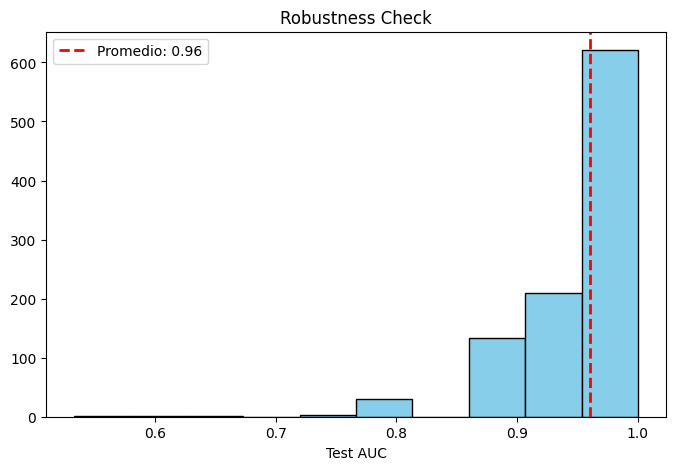

In [18]:
X_arr = X.values if hasattr(X, "values") else X
y_arr = y.values if hasattr(y, "values") else y

selected_mask = res.X[idx_balanced]
best_mask = selected_mask
auc_scores = []
n_iterations = 1000

for i in range(n_iterations):
    # 1. Split aleatorio nuevo cada vez
    X_train_loop, X_test_loop, y_train_loop, y_test_loop = train_test_split(
        X_arr, y_arr, test_size=0.3, stratify=y_arr, random_state=i
    )

    # 2. Seleccionar solo las features óptimas
    X_tr_sel = X_train_loop[:, selected_mask]
    X_te_sel = X_test_loop[:, selected_mask]

    # 3. Entrenar y Testear
    clf = LogisticRegression(class_weight='balanced', solver='liblinear', max_iter=1000)
    clf.fit(X_tr_sel, y_train_loop)

    # Predecir
    try:
        y_pred = clf.predict_proba(X_te_sel)[:, 1]
        score = roc_auc_score(y_test_loop, y_pred)
        auc_scores.append(score)
    except:
        continue

mean_auc = np.mean(auc_scores)
std_auc = np.std(auc_scores)

print(f"\nStatistics (after {n_iterations} splits)")
print(f"Mean AUC: {mean_auc:.3f}")
print(f"Sigma: +/- {std_auc:.3f}")

plt.figure(figsize=(8, 5))
plt.hist(auc_scores, bins=10, color='skyblue', edgecolor='black')
plt.axvline(mean_auc, color='red', linestyle='dashed', linewidth=2, label=f'Promedio: {mean_auc:.2f}')
plt.title('Robustness Check')
plt.xlabel('Test AUC')
plt.legend()
plt.show()

In [19]:
if 'feature_names' not in locals():
    feature_names = df_final.drop(columns=["Subject", "Target"]).columns

Calculando curva Baseline (SelectKBest)...


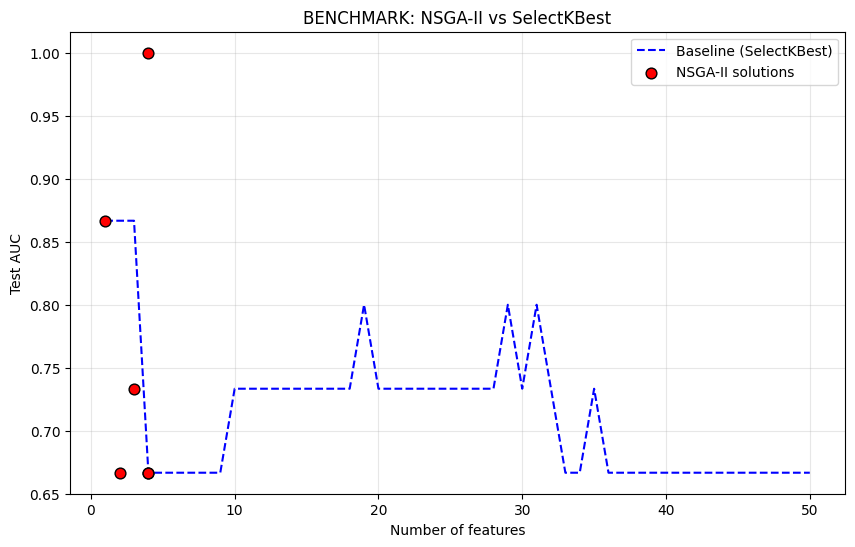

In [20]:
# BENCHMARK: NSGA-II vs SelectKBest

# 1. Calcular Baseline (SelectKBest) para k=1 hasta 50
k_values = range(1, 51)
baseline_scores_test = []

# Convertimos a numpy
X_tr_arr = X_train.values if hasattr(X_train, "values") else X_train
X_te_arr = X_test.values if hasattr(X_test, "values") else X_test

print("Calculando curva Baseline (SelectKBest)...")
for k in k_values:
    selector = SelectKBest(f_classif, k=k)
    X_tr_k = selector.fit_transform(X_tr_arr, y_train)
    X_te_k = selector.transform(X_te_arr)

    # Entrenar mismo modelo (LogReg)
    clf = LogisticRegression(class_weight='balanced', solver='liblinear', random_state=42, max_iter=1000)
    clf.fit(X_tr_k, y_train)

    # Evaluar en Test
    if hasattr(clf, "predict_proba"):
        y_scores = clf.predict_proba(X_te_k)[:, 1]
    else:
        y_scores = clf.decision_function(X_te_k)

    baseline_scores_test.append(roc_auc_score(y_test, y_scores))

nsga_feats = []
nsga_auc_test = []

for mask in res.X:
    if mask.sum() == 0: continue
    nsga_feats.append(mask.sum())
    X_tr_sub = X_tr_arr[:, mask]
    X_te_sub = X_te_arr[:, mask]
    clf = LogisticRegression(class_weight='balanced', solver='liblinear', random_state=42, max_iter=1000)
    clf.fit(X_tr_sub, y_train)
    score = roc_auc_score(y_test, clf.predict_proba(X_te_sub)[:, 1])
    nsga_auc_test.append(score)

# 3. PLOT
plt.figure(figsize=(10, 6))
plt.plot(k_values, baseline_scores_test, label='Baseline (SelectKBest)', color='blue', linestyle='--')
plt.scatter(nsga_feats, nsga_auc_test, color='red', s=60, edgecolors='k', label='NSGA-II solutions', zorder=5)

plt.xlabel('Number of features')
plt.ylabel('Test AUC')
plt.title('BENCHMARK: NSGA-II vs SelectKBest')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

                Modelo  Test AUC   Test F1
0  Logistic Regression  1.000000  0.750000
1     SVM (RBF Kernel)  0.866667  0.666667
2        Random Forest  0.866667  0.750000
3              XGBoost  0.966667  0.750000


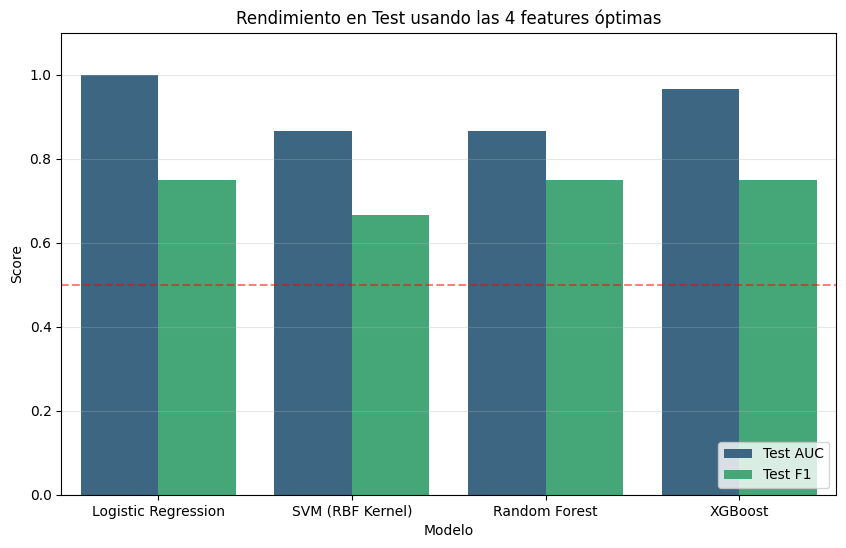

In [22]:
# MULTI-MODEL VALIDATION (With F1)
num_feats = selected_mask.sum()

# Prepare reduced data
X_tr_opt = X_tr_arr[:, best_mask]
X_te_opt = X_te_arr[:, best_mask]

# Dictionary of models
models = {
    "Logistic Regression": LogisticRegression(class_weight='balanced', solver='liblinear', random_state=42),
    "SVM (RBF Kernel)": SVC(class_weight='balanced', probability=True, random_state=42),
    "Random Forest": RandomForestClassifier(class_weight='balanced', random_state=42, max_depth=5),
    "XGBoost": XGBClassifier(eval_metric='logloss', use_label_encoder=False, random_state=42)
}

results_model = []

for name, model in models.items():
    model.fit(X_tr_opt, y_train)

    # 1. Probabilities for AUC
    y_prob = model.predict_proba(X_te_opt)[:, 1]
    auc = roc_auc_score(y_test, y_prob)

    # 2. Binary Class Predictions for F1
    y_pred = model.predict(X_te_opt)
    f1 = f1_score(y_test, y_pred)

    results_model.append({
        'Modelo': name,
        'Test AUC': auc,
        'Test F1': f1
    })

# Table
df_results = pd.DataFrame(results_model)
print(df_results)

# Transform data for plotting
df_melted = df_results.melt(id_vars="Modelo", var_name="Metric", value_name="Score")

# Plot grouped bars
plt.figure(figsize=(10, 6))
sns.barplot(data=df_melted, x='Modelo', y='Score', hue='Metric', palette='viridis')

plt.title(f'Rendimiento en Test usando las {num_feats} features óptimas')
plt.ylim(0, 1.1)
plt.axhline(0.5, color='red', linestyle='--', alpha=0.5)
plt.grid(axis='y', alpha=0.3)
plt.legend(loc='lower right')
plt.show()

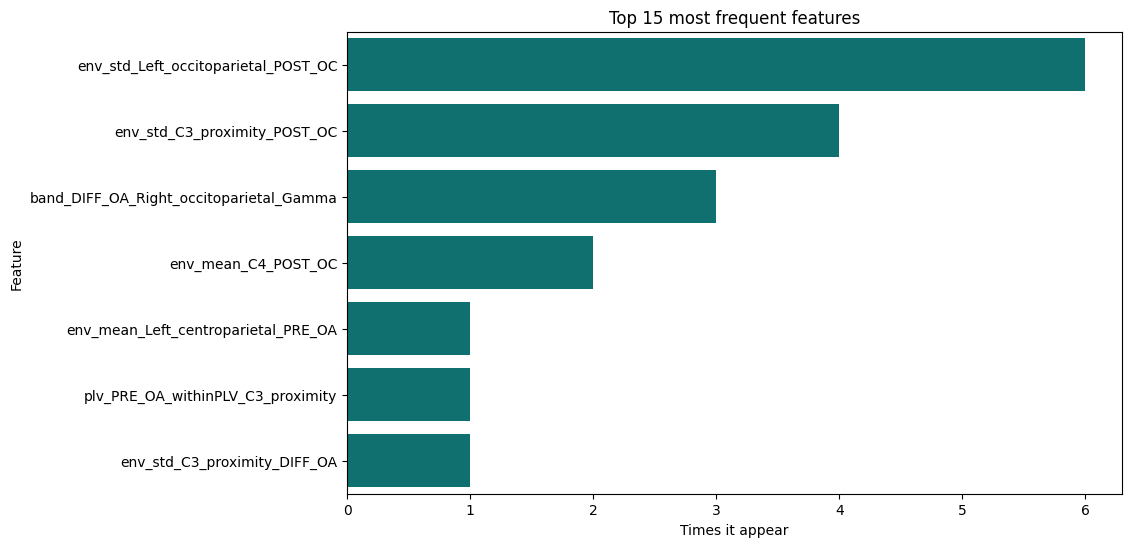

In [23]:
# FREQUENCY ANALYSIS (Feature Stability)

feature_counts = res.X.sum(axis=0)

stability_df = pd.DataFrame({
    'Feature': feature_names,
    'Frequency': feature_counts
})

stability_df = stability_df[stability_df['Frequency'] > 0].sort_values(by='Frequency', ascending=False)

# Top 15 features
top_n = 15
plt.figure(figsize=(10, 6))
sns.barplot(data=stability_df.head(top_n), x='Frequency', y='Feature', color='teal')
plt.title(f'Top {top_n} most frequent features')
plt.xlabel('Times it appear')
plt.show()

In [24]:
# SELECTED SOLUTION INSPECTION

selected_feats = feature_names[selected_mask]

print(f"Biomarkers selected ({len(selected_feats)}) ---")
for f in selected_feats:
    print(f"- {f}")

Biomarkers selected (4) ---
- env_mean_C4_POST_OC
- env_std_Left_occitoparietal_POST_OC
- plv_PRE_OA_withinPLV_C3_proximity
- band_DIFF_OA_Right_occitoparietal_Gamma


   -> Explaining Logistic Regression...


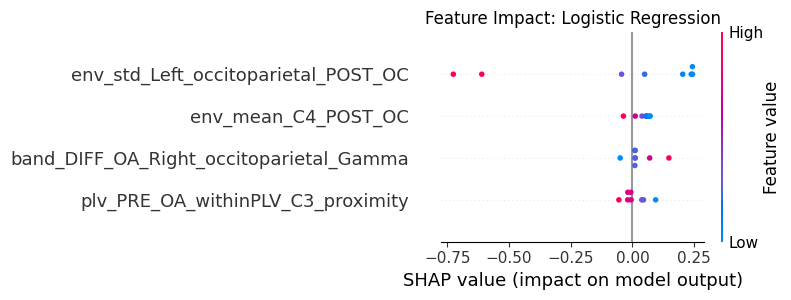

   -> Done.

   -> Explaining SVM (RBF)...


  0%|          | 0/8 [00:00<?, ?it/s]

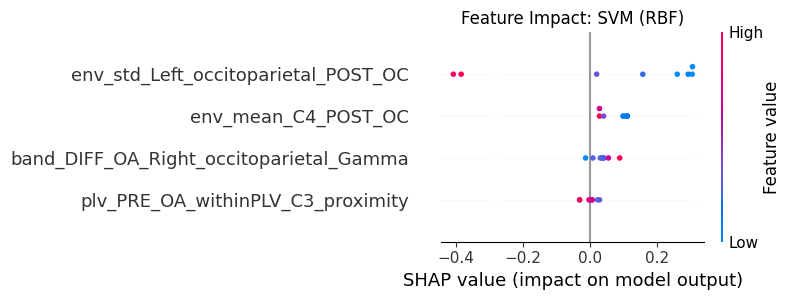

   -> Done.

   -> Explaining Random Forest...


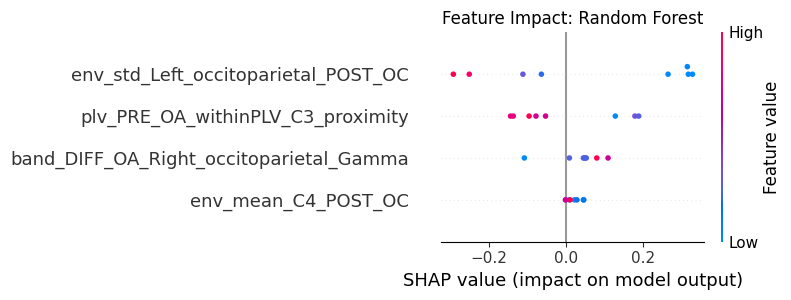

   -> Done.

   -> Explaining XGBoost...


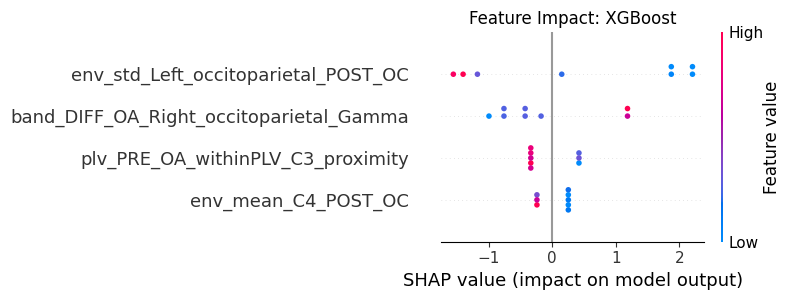

   -> Done.



In [25]:
#SHAP
warnings.filterwarnings('ignore')

best_mask = res.X[idx_balanced]
selected_feats = feature_names[best_mask]

if hasattr(X_train, "values"):
    X_tr_np = X_train.values[:, best_mask]
    X_te_np = X_test.values[:, best_mask]
else:
    X_tr_np = X_train[:, best_mask]
    X_te_np = X_test[:, best_mask]

# Convert to DataFrame with names
X_tr_shap = pd.DataFrame(X_tr_np, columns=list(selected_feats))
X_te_shap = pd.DataFrame(X_te_np, columns=list(selected_feats))

# Define and Train Models
models_shap = {
    "Logistic Regression": LogisticRegression(class_weight='balanced', solver='liblinear', random_state=42),
    "SVM (RBF)": SVC(class_weight='balanced', probability=True, random_state=42),
    "Random Forest": RandomForestClassifier(class_weight='balanced', random_state=42, max_depth=5),
    "XGBoost": XGBClassifier(eval_metric='logloss', use_label_encoder=False, random_state=42)
}

# SHAP function
def get_shap_values_robust(model, model_name, X_train, X_test):
    """
    Handles the inconsistency between Linear, Tree, and Kernel explainers.
    Automatically detects if output is a list (Binary) or array.
    """
    print(f"   -> Explaining {model_name}...")

    # A. Linear Models
    if "Logistic" in model_name:
        masker = shap.maskers.Independent(data=X_train)
        explainer = shap.LinearExplainer(model, masker=masker)
        values = explainer.shap_values(X_test)

    # B. Tree Models
    elif "XGBoost" in model_name or "Random Forest" in model_name:
        explainer = shap.TreeExplainer(model)
        values = explainer.shap_values(X_test)

    # C. Kernel Models (SVM) - Slow, needs summary
    else:
        X_summary = shap.kmeans(X_train, 5)
        explainer = shap.KernelExplainer(model.predict_proba, X_summary)
        values = explainer.shap_values(X_test, nsamples=100)

    if isinstance(values, list):
        print("      (Detected List output, selecting Class 1...)")
        return values[1]

    elif len(values.shape) == 3:
        return values[:, :, 1]

    else:
        return values

# Loop
for name, model in models_shap.items():
    # Train
    model.fit(X_tr_shap, y_train)

    try:
        # Calculate
        shap_vals = get_shap_values_robust(model, name, X_tr_shap, X_te_shap)

        # Plot
        plt.figure(figsize=(8, 5))
        plt.title(f"Feature Impact: {name}")
        shap.summary_plot(shap_vals, X_te_shap, show=False)
        plt.tight_layout()
        plt.show()
        print("   -> Done.\n")

    except Exception as e:
        print(f"!!! CRITICAL FAIL on {name}: {str(e)}")

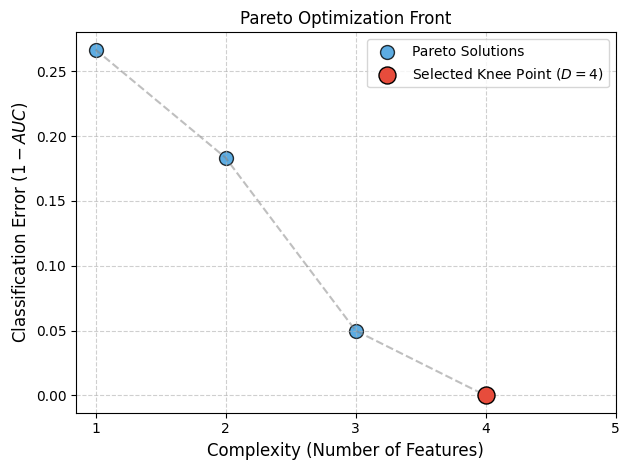

In [26]:
F = res.F
objectives = F

# 1. Convert Data to Real Units
error = objectives[:, 0]
features = np.round(objectives[:, 1] * 642).astype(int)

# 2. Create Plot
plt.figure()

# Plot all points
plt.scatter(features, error, color='#3498db', s=100, alpha=0.8, edgecolors='k', label='Pareto Solutions')

# 3. Highlight the "Knee Point" (4 Features, 0 Error)
knee_index = idx_balanced
plt.scatter(features[knee_index], error[knee_index], color='#e74c3c', s=150, edgecolors='k', zorder=5, label='Selected Knee Point ($D=4$)')

sorted_indices = np.argsort(features)
plt.plot(features[sorted_indices], error[sorted_indices], '--', color='gray', alpha=0.5)
plt.title('Pareto Optimization Front')
plt.xlabel('Complexity (Number of Features)', fontsize=12)
plt.ylabel('Classification Error ($1 - AUC$)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(loc='upper right')
plt.xticks(np.arange(min(features), max(features)+2, 1))

plt.tight_layout()
plt.savefig('Pareto_Front.png')
plt.show()